In [ ]:
# Import

import os

from tqdm import tqdm
import torch # Pytorch
import torchvision # Pytorch per le immagini e il video
from torch import nn
from torch.utils.data import DataLoader # Wrapper per il dataset
from torchvision import transforms # Trasformazioni dei dati
from torchvision.datasets import MNIST # Download del dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:
# Settiamo gli hyperparametri
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [ ]:
# Trasformazioni delle immagini

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Scarichiamo il dataset e inseriamolo nel dataloader
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 36210950.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119228045.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44299980.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16696344.23it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Definiamo la classe dell'Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Definiamo un'istanza dell'Autoencoder
model = Autoencoder()
model = model.cuda()

# Definiamo la loss function
criterion = nn.MSELoss()

# Definiamo l'ottimizzatore
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

# Definiamo il processo di allenamento
for epoch in tqdm(range(num_epochs)):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.cuda()
        # forward pass
        output = model(img)
        loss = criterion(output, img)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.1674
epoch [2/100], loss:0.1540
epoch [3/100], loss:0.1532
epoch [4/100], loss:0.1488
epoch [5/100], loss:0.1515
epoch [6/100], loss:0.1382
epoch [7/100], loss:0.1365
epoch [8/100], loss:0.1532
epoch [9/100], loss:0.1517
epoch [10/100], loss:0.1346
epoch [11/100], loss:0.1303
epoch [12/100], loss:0.1242
epoch [13/100], loss:0.1260
epoch [14/100], loss:0.1197
epoch [15/100], loss:0.1273
epoch [16/100], loss:0.1448
epoch [17/100], loss:0.1284
epoch [18/100], loss:0.1336
epoch [19/100], loss:0.1248
epoch [20/100], loss:0.1167
epoch [21/100], loss:0.1371
epoch [22/100], loss:0.1318
epoch [23/100], loss:0.1275
epoch [24/100], loss:0.1378
epoch [25/100], loss:0.1353
epoch [26/100], loss:0.1359
epoch [27/100], loss:0.1266
epoch [28/100], loss:0.1218
epoch [29/100], loss:0.1271
epoch [30/100], loss:0.1222
epoch [31/100], loss:0.1296
epoch [32/100], loss:0.1239
epoch [33/100], loss:0.1317
epoch [34/100], loss:0.1410
epoch [35/100], loss:0.1236
epoch [36/100], loss:0.1191
e

In [ ]:
# Scarichiamo il dataset per il test e inseriamolo nel dataloader
dataset = MNIST('./data', transform=img_transform, download=True, train=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

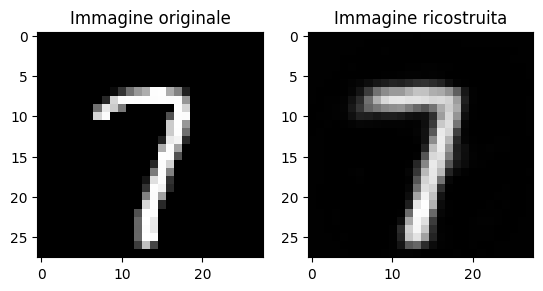

In [ ]:
# Testiamo il modello sul test set
for data in dataloader:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = img.cuda()
    # forward pass
    output = model(img)
    output = output.detach().cpu()
    pic = to_img(output)
    plt.subplot(1,2,1)
    plt.imshow(to_img(img).cpu()[0][0], cmap="gray")
    plt.title("Immagine originale")
    plt.subplot(1,2,2)
    plt.imshow(pic[0][0], cmap="gray")
    plt.title("Immagine ricostruita")

In questo notebook abbiamo utilizzato un autoencoder estremamente semplice, con layer fully connected. In pratica, gli autoencoder basati su reti convoluzionali (torch.nn.Conv2d) sono molto più potenti.

Un esempio è il seguente:

In [ ]:
# Definiamo la classe dell'Autoencoder convoluzionale
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Con nn.Conv2d dimiuiamo la dimensione dell'immagine
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        # Con nn.ConvTranspose2d aumentiamo la dimensione dello spazio latente fino alla dimensione dell'immagine da ricostruire
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=1, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded